In [185]:
import pandas as pd
import numpy as np

In [186]:
# 1. Load Data
matches = pd.read_csv('matches.csv')
deliveries = pd.read_csv('deliveries.csv')

In [187]:
# 2. Feature Engineering (Creating new useful columns)
# A batter doesn't "face" a ball if it's a wide (it doesn't count towards their ball count)
deliveries['is_wide'] = deliveries['wides'].apply(lambda x: 1 if x > 0 else 0)
deliveries['batter_balls_faced'] = deliveries['is_wide'].apply(lambda x: 0 if x == 1 else 1)

# A bowler "bowls" a legal ball if it's not a wide or no-ball
deliveries['is_noball'] = deliveries['noballs'].apply(lambda x: 1 if x > 0 else 0)
deliveries['legal_ball'] = deliveries.apply(lambda x: 0 if (x['is_wide'] == 1 or x['is_noball'] == 1) else 1, axis=1)

In [188]:
# 3. Aggregation (Grouping ball-by-ball data into Player Stats)
# --- Batting Stats ---
batting_stats = deliveries.groupby('striker').agg({
    'runs_off_bat': 'sum',
    'batter_balls_faced': 'sum',
    'match_id': 'nunique' # Counts unique matches played
}).reset_index()
batting_stats.columns = ['player', 'runs', 'balls_faced', 'matches_played']
batting_stats['batting_sr'] = (batting_stats['runs'] / batting_stats['balls_faced'] * 100).round(2)

# --- Bowling Stats ---
# Filter for wickets that count for the bowler (exclude run-outs)
valid_wickets = ['caught', 'bowled', 'lbw', 'stumped', 'caught and bowled', 'hit wicket']
deliveries['is_bowler_wicket'] = deliveries['wicket_type'].isin(valid_wickets).astype(int)
# Calculate runs conceded by bowler (includes wides/noballs, but not legbyes)
deliveries['bowler_runs_conceded'] = deliveries['runs_off_bat'] + deliveries['wides'].fillna(0) + deliveries['noballs'].fillna(0)

bowling_stats = deliveries.groupby('bowler').agg({
    'bowler_runs_conceded': 'sum',
    'legal_ball': 'sum',
    'is_bowler_wicket': 'sum'
}).reset_index()
bowling_stats.columns = ['player', 'runs_conceded', 'balls_bowled', 'wickets']
bowling_stats['economy_rate'] = (bowling_stats['runs_conceded'] / (bowling_stats['balls_bowled'] / 6)).round(2)

In [189]:
# 4. Merging Batting and Bowling Stats
final_stats = pd.merge(batting_stats, bowling_stats, on='player', how='outer').fillna(0)

# Filter: Remove players who barely played (e.g., faced < 30 balls or bowled < 12 balls)
final_stats = final_stats[(final_stats['balls_faced'] > 30) | (final_stats['balls_bowled'] > 12)]

# Show top performers
print("Top Run Scorers:")
print(final_stats.sort_values('runs', ascending=False).head(5)[['player', 'runs', 'batting_sr']])

print("\nTop Wicket Takers:")
print(final_stats.sort_values('wickets', ascending=False).head(5)[['player', 'wickets', 'economy_rate']])

Top Run Scorers:
                 player   runs  batting_sr
211  Rahmanullah Gurbaz  281.0      124.34
204           RG Sharma  257.0      156.71
252             TM Head  255.0      158.39
194           Q de Kock  243.0      140.46
86       Ibrahim Zadran  231.0      107.44

Top Wicket Takers:
               player  wickets  economy_rate
25     Arshdeep Singh     17.0          7.17
67   Fazalhaq Farooqi     17.0          6.32
5            A Nortje     15.0          5.74
96          JJ Bumrah     15.0          4.18
215    Rishad Hossain     14.0          7.76


C:\Users\sanja\AppData\Local\Temp\ipykernel_24124\1482798347.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player', y='runs', data=top_scorers, palette='viridis')


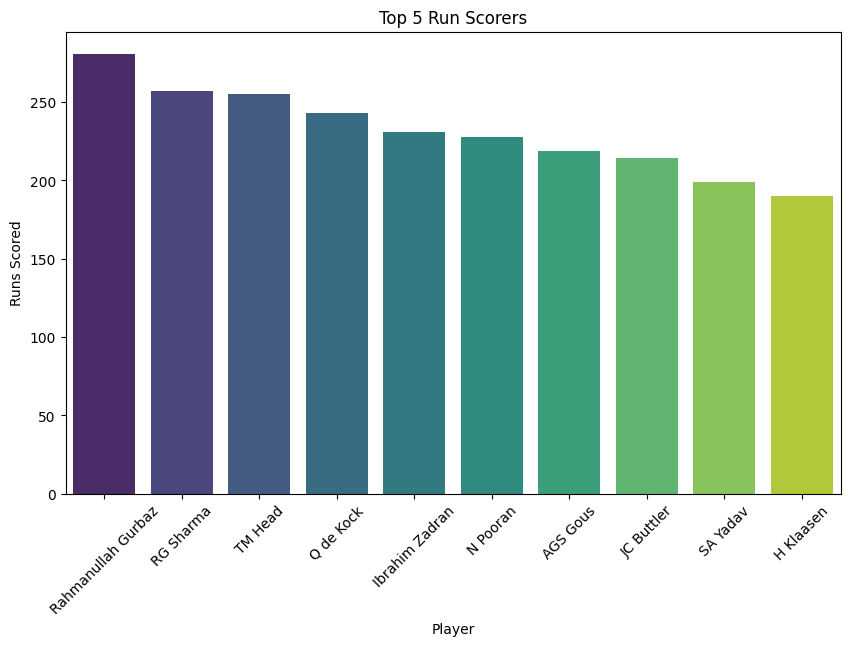

In [190]:
#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
#visualize top 10 run scorers
top_scorers = final_stats.sort_values('runs', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='player', y='runs', data=top_scorers, palette='viridis')
plt.title('Top 5 Run Scorers')
plt.xlabel('Player')
plt.ylabel('Runs Scored')
plt.xticks(rotation=45)
plt.show()

C:\Users\sanja\AppData\Local\Temp\ipykernel_24124\4242460423.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player', y='wickets', data=top_bowlers, palette='magma')


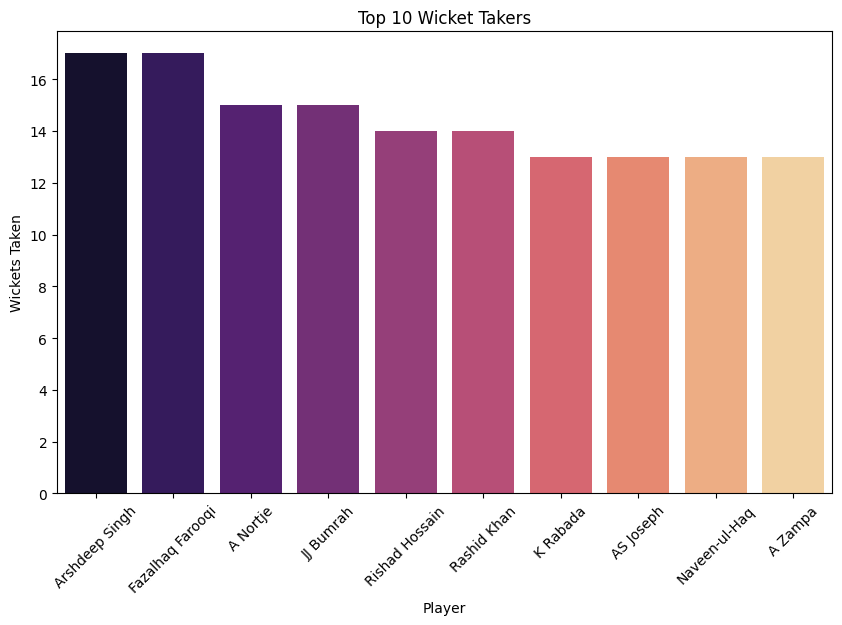

In [191]:
top_bowlers = final_stats.sort_values('wickets', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='player', y='wickets', data=top_bowlers, palette='magma')
plt.title('Top 10 Wicket Takers')    
plt.xlabel('Player')
plt.ylabel('Wickets Taken')
plt.xticks(rotation=45)
plt.show()

C:\Users\sanja\AppData\Local\Temp\ipykernel_24124\2600465414.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='venue', x='avg_runs_per_match', data=top_grounds, palette='coolwarm')


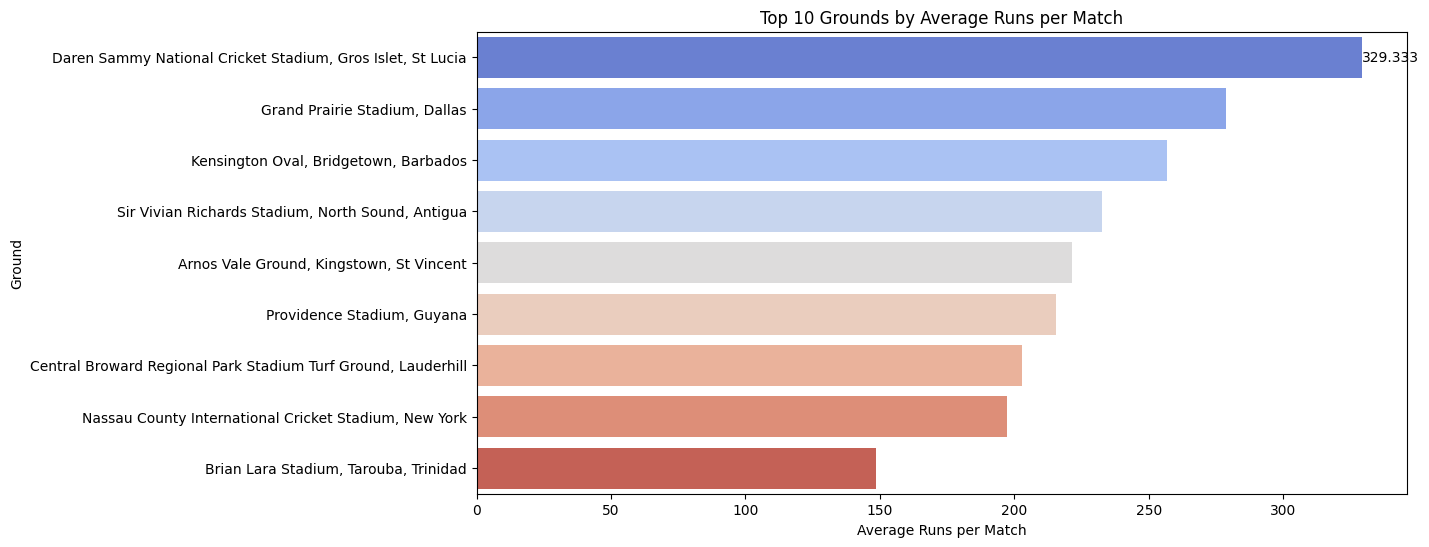

In [192]:
#average runs per ground
avg_runs_per_ground = deliveries.groupby('venue').agg({
    'runs_off_bat': 'sum',
    'match_id': 'nunique'
}).reset_index()
avg_runs_per_ground['avg_runs_per_match'] = (avg_runs_per_ground['runs_off_bat'] / avg_runs_per_ground['match_id'])
plt.figure(figsize=(12,6))
top_grounds = avg_runs_per_ground.sort_values('avg_runs_per_match', ascending=False).head(10)
sns.barplot(y='venue', x='avg_runs_per_match', data=top_grounds, palette='coolwarm')
plt.title('Top 10 Grounds by Average Runs per Match')
plt.ylabel('Ground')
plt.xlabel('Average Runs per Match')
plt.bar_label(plt.gca().containers[0])
plt.show()

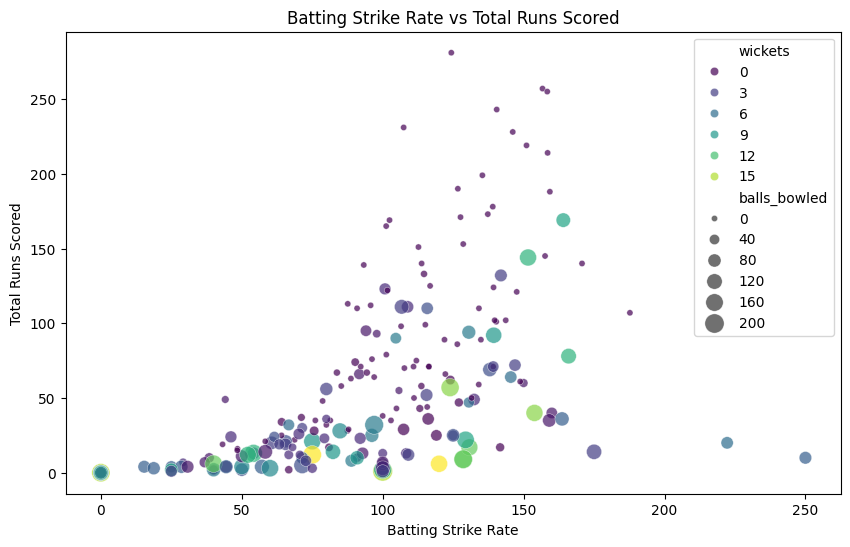

In [193]:
#strike rate vs average runs scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x='batting_sr', y='runs', data=final_stats, hue='wickets', size='balls_bowled', sizes=(20, 200), alpha=0.7, palette='viridis')
plt.title('Batting Strike Rate vs Total Runs Scored')
plt.xlabel('Batting Strike Rate')
plt.ylabel('Total Runs Scored')
plt.show()

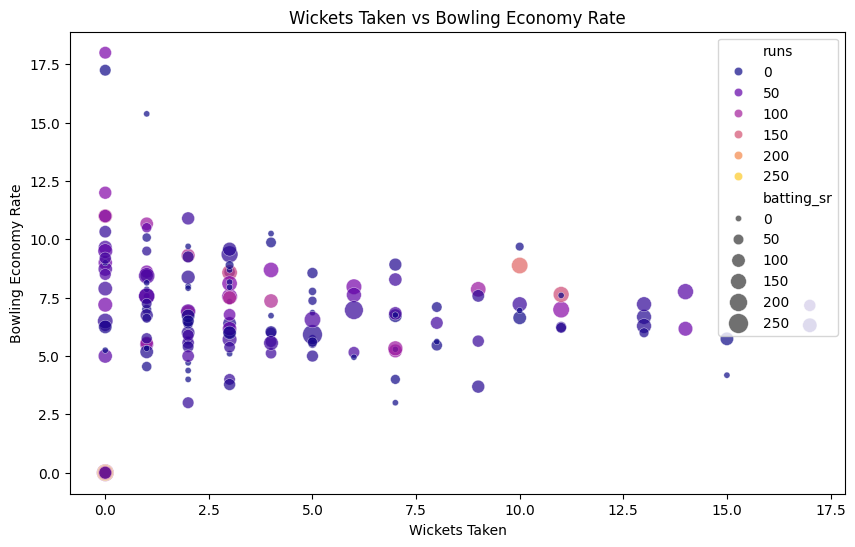

In [194]:
#wickwts vs economy rate scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x='wickets', y='economy_rate', data=final_stats, hue='runs', size='batting_sr', sizes=(20, 200), alpha=0.7, palette='plasma')
plt.title('Wickets Taken vs Bowling Economy Rate')
plt.xlabel('Wickets Taken')
plt.ylabel('Bowling Economy Rate')
plt.show()

In [195]:
# --- Calculate Batting Average ---
# Count how many times each player got out
outs = deliveries[deliveries['player_dismissed'].notnull()]['player_dismissed'].value_counts().reset_index()
outs.columns = ['player', 'outs']

# Merge 'outs' into your final_stats
final_stats = pd.merge(final_stats, outs, on='player', how='left').fillna(0)

# If a player never got out, we divide by 1 instead of 0 to avoid errors
final_stats['outs'] = final_stats['outs'].apply(lambda x: 1 if x == 0 else x)
final_stats['batting_avg'] = (final_stats['runs'] / final_stats['outs']).round(2)

print("Added Batting Average. Here are the top 5 consistent batters:")
print(final_stats.sort_values('batting_avg', ascending=False).head(5)[['player', 'batting_avg', 'runs']])

Added Batting Average. Here are the top 5 consistent batters:
            player  batting_avg   runs
172  RD Berrington        102.0  102.0
67        HC Brook         72.5  145.0
33     BJ McMullen         70.0  140.0
192        SD Hope         53.5  107.0
69       HH Pandya         48.0  144.0


In [196]:
# Helper function to normalize values (scale them between 0 and 1)
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Create Batting Score: Weighted mix of Runs (50%), SR (30%), Avg (20%)
final_stats['bat_score'] = 0.5 * normalize(final_stats['runs']) + 0.3 * normalize(final_stats['batting_sr']) + 0.2 * normalize(final_stats['batting_avg'])

# Create Bowling Score: Weighted mix of Wickets (60%) and Economy (40%)
# Note: Lower Economy is better, so we use (1 - normalized_economy)
final_stats['bowl_score'] = 0.6 * normalize(final_stats['wickets']) + 0.4 * (1 - normalize(final_stats['economy_rate']))

print("\nScores Calculated. Ready to select team.")


Scores Calculated. Ready to select team.


In [197]:
# Select Top 6 Batters
best_batters = final_stats.sort_values('bat_score', ascending=False).head(6)

# Select Top 5 Bowlers (who are not already in the batter list)
best_bowlers = final_stats[~final_stats['player'].isin(best_batters['player'])].sort_values('bowl_score', ascending=False).head(5)

# Combine them
final_xi = pd.concat([best_batters, best_bowlers])

print("\n--- 🏆 YOUR DATA-DRIVEN T20 WORLD CUP XI ---")
print(final_xi[['player', 'runs', 'batting_sr', 'wickets', 'economy_rate']])


--- 🏆 YOUR DATA-DRIVEN T20 WORLD CUP XI ---
                 player   runs  batting_sr  wickets  economy_rate
212             TM Head  255.0      158.39      0.0          0.00
179  Rahmanullah Gurbaz  281.0      124.34      0.0          0.00
173           RG Sharma  257.0      156.71      0.0          0.00
11             AGS Gous  219.0      151.03      0.0          0.00
144            N Pooran  228.0      146.15      0.0          0.00
80           JC Buttler  214.0      158.52      0.0          0.00
58     Fazalhaq Farooqi    6.0      120.00     17.0          6.32
24       Arshdeep Singh   12.0       75.00     17.0          7.17
82            JJ Bumrah    0.0        0.00     15.0          4.18
5              A Nortje    1.0      100.00     15.0          5.74
180         Rashid Khan   57.0      123.91     14.0          6.17


In [198]:
#high strike rate and high average batsmen in the final xi
high_sr_avg_batsmen = final_xi[(final_xi['batting_sr'] > final_xi['batting_sr'].median()) & (final_xi['batting_avg'] > final_xi['batting_avg'].median())]
print("\nBatsmen in Final XI with High Strike Rate and High Average:")
print(high_sr_avg_batsmen[['player', 'runs', 'batting_sr', 'batting_avg']])



Batsmen in Final XI with High Strike Rate and High Average:
         player   runs  batting_sr  batting_avg
212     TM Head  255.0      158.39         42.5
11     AGS Gous  219.0      151.03         43.8
144    N Pooran  228.0      146.15         38.0
80   JC Buttler  214.0      158.52         42.8


C:\Users\sanja\AppData\Local\Temp\ipykernel_24124\606318475.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=high_sr_avg_batsmen, x='player', y='runs', palette='Blues_d')


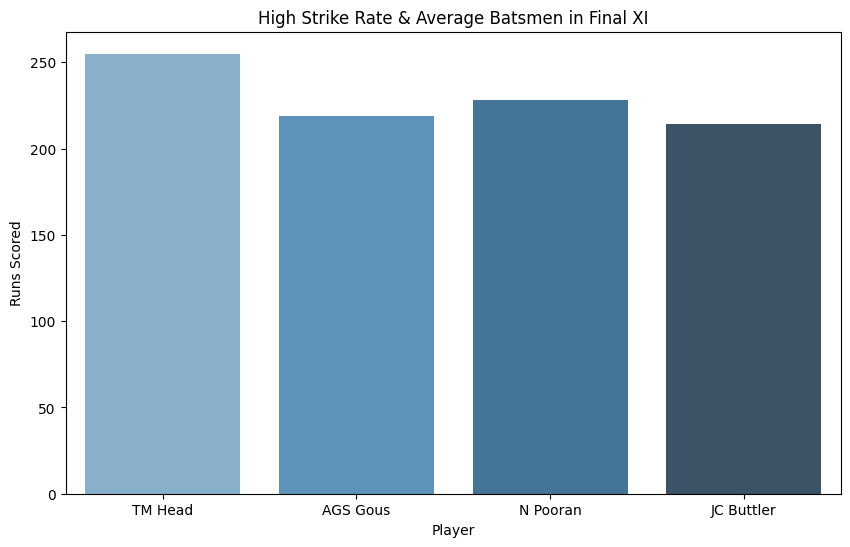

In [199]:
plt.figure(figsize=(10,6))
sns.barplot(data=high_sr_avg_batsmen, x='player', y='runs', palette='Blues_d')
plt.title('High Strike Rate & Average Batsmen in Final XI')
plt.xlabel('Player')
plt.ylabel('Runs Scored')
plt.show()

In [200]:
#high strike rate and high average batsmen overall
high_sr_avg_batsmen = final_stats[(final_stats['batting_sr'] > final_stats['batting_sr'].median()) & (final_stats['batting_avg'] > final_stats['batting_avg'].median())]
print("\nBatsmen Overall with High Strike Rate and High Average:")
print(high_sr_avg_batsmen[['player', 'runs', 'batting_sr', 'batting_avg']])



Batsmen Overall with High Strike Rate and High Average:
            player   runs  batting_sr  batting_avg
2           A Dutt   25.0      125.00        25.00
3        A Johnson   89.0      121.92        29.67
9       AD Mathews   62.0      124.00        31.00
10      AD Russell   78.0      165.96        26.00
11        AGS Gous  219.0      151.03        43.80
..             ...    ...         ...          ...
207       T Stubbs  165.0      101.23        33.00
210       TH David   61.0      148.78        15.25
212        TM Head  255.0      158.39        42.50
217  Towhid Hridoy  153.0      128.57        21.86
218        V Kohli  151.0      112.69        18.88

[89 rows x 4 columns]


C:\Users\sanja\AppData\Local\Temp\ipykernel_24124\3006832520.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player', y='runs', data=top_scorers, palette='viridis')
C:\Users\sanja\AppData\Local\Temp\ipykernel_24124\3006832520.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player', y='wickets', data=top_bowlers, palette='magma')
C:\Users\sanja\AppData\Local\Temp\ipykernel_24124\3006832520.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='venue', x='avg_runs_per_match', data=top_grounds, palette='coolwarm')


Added Batting Average. Here are the top 5 consistent batters:
            player  batting_avg   runs
172  RD Berrington        102.0  102.0
67        HC Brook         72.5  145.0
33     BJ McMullen         70.0  140.0
192        SD Hope         53.5  107.0
69       HH Pandya         48.0  144.0

Scores Calculated. Ready to select team.

--- 🏆 YOUR DATA-DRIVEN T20 WORLD CUP XI ---
                 player   runs  batting_sr  wickets  economy_rate
212             TM Head  255.0      158.39      0.0          0.00
179  Rahmanullah Gurbaz  281.0      124.34      0.0          0.00
173           RG Sharma  257.0      156.71      0.0          0.00
11             AGS Gous  219.0      151.03      0.0          0.00
144            N Pooran  228.0      146.15      0.0          0.00
80           JC Buttler  214.0      158.52      0.0          0.00
58     Fazalhaq Farooqi    6.0      120.00     17.0          6.32
24       Arshdeep Singh   12.0       75.00     17.0          7.17
82            JJ Bumrah

C:\Users\sanja\AppData\Local\Temp\ipykernel_24124\3006832520.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=high_sr_avg_batsmen, x='player', y='runs', palette='Blues_d')


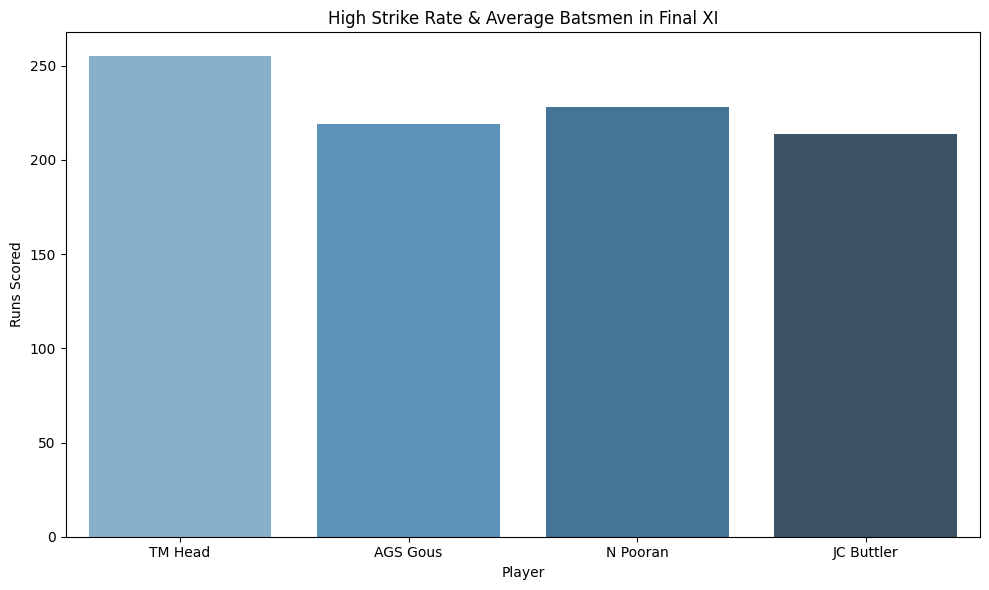


Batsmen Overall with High Strike Rate and High Average:
            player   runs  batting_sr  batting_avg
2           A Dutt   25.0      125.00        25.00
3        A Johnson   89.0      121.92        29.67
9       AD Mathews   62.0      124.00        31.00
10      AD Russell   78.0      165.96        26.00
11        AGS Gous  219.0      151.03        43.80
..             ...    ...         ...          ...
207       T Stubbs  165.0      101.23        33.00
210       TH David   61.0      148.78        15.25
212        TM Head  255.0      158.39        42.50
217  Towhid Hridoy  153.0      128.57        21.86
218        V Kohli  151.0      112.69        18.88

[89 rows x 4 columns]
                 player   runs  batting_sr
179  Rahmanullah Gurbaz  281.0      124.34
173           RG Sharma  257.0      156.71
212             TM Head  255.0      158.39
165           Q de Kock  243.0      140.46
73       Ibrahim Zadran  231.0      107.44


<Figure size 640x480 with 0 Axes>

In [204]:
#saving graphs to files
plt.figure(figsize=(10,6))
sns.barplot(x='player', y='runs', data=top_scorers, palette='viridis')
plt.title('Top 5 Run Scorers')
plt.xlabel('Player')
plt.ylabel('Runs Scored')
plt.tight_layout()
plt.savefig('top_5_run_scorers.png')
plt.close()

plt.figure(figsize=(10,6))
sns.barplot(x='player', y='wickets', data=top_bowlers, palette='magma')
plt.title('Top 10 Wicket Takers')
plt.xlabel('Player')
plt.ylabel('Wickets Taken')
plt.tight_layout()
plt.savefig('top_10_wicket_takers.png')
plt.close()

plt.figure(figsize=(12,6))
sns.barplot(y='venue', x='avg_runs_per_match', data=top_grounds, palette='coolwarm')
plt.title('Top 10 Grounds by Average Runs per Match')
plt.ylabel('Ground')
plt.xlabel('Average Runs per Match')
plt.tight_layout()
plt.savefig('top_10_grounds_avg_runs.png')
plt.close()

plt.figure(figsize=(10,6))
sns.scatterplot(x='batting_sr', y='runs', data=final_stats, hue='wickets', size='balls_bowled', sizes=(20, 200), alpha=0.7, palette='viridis')
plt.title('Batting Strike Rate vs Total Runs Scored')
plt.xlabel('Batting Strike Rate')
plt.ylabel('Total Runs Scored')
plt.tight_layout()
plt.savefig('batting_sr_vs_runs.png')
plt.close()

plt.figure(figsize=(10,6))
sns.scatterplot(x='wickets', y='economy_rate', data=final_stats, hue='runs', size='batting_sr', sizes=(20, 200), alpha=0.7, palette='plasma')
plt.title('Wickets Taken vs Bowling Economy Rate')
plt.xlabel('Wickets Taken')
plt.ylabel('Bowling Economy Rate')
plt.tight_layout()
plt.savefig('wickets_vs_economy_rate.png')
plt.close()

# --- Calculate Batting Average ---
# Count how many times each player got out
outs = deliveries[deliveries['player_dismissed'].notnull()]['player_dismissed'].value_counts().reset_index()
outs.columns = ['player', 'outs']

# Ensure we don't create duplicate 'outs' columns when re-running this cell
final_stats = final_stats.drop(columns=['outs'], errors=True)
# Merge 'outs' into your final_stats
final_stats = pd.merge(final_stats, outs, on='player', how='left').fillna(0)

# If a player never got out, we divide by 1 instead of 0 to avoid errors
final_stats['outs'] = final_stats['outs'].apply(lambda x: 1 if x == 0 else x)
final_stats['batting_avg'] = (final_stats['runs'] / final_stats['outs']).round(2)

print("Added Batting Average. Here are the top 5 consistent batters:")
print(final_stats.sort_values('batting_avg', ascending=False).head(5)[['player', 'batting_avg', 'runs']])

# Helper function to normalize values (scale them between 0 and 1)
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Create Batting Score: Weighted mix of Runs (50%), SR (30%), Avg (20%)
final_stats['bat_score'] = 0.5 * normalize(final_stats['runs']) + 0.3 * normalize(final_stats['batting_sr']) + 0.2 * normalize(final_stats['batting_avg'])

# Create Bowling Score: Weighted mix of Wickets (60%) and Economy (40%)
# Note: Lower Economy is better, so we use (1 - normalized_economy)
final_stats['bowl_score'] = 0.6 * normalize(final_stats['wickets']) + 0.4 * (1 - normalize(final_stats['economy_rate']))

print("\nScores Calculated. Ready to select team.")

# Select Top 6 Batters
best_batters = final_stats.sort_values('bat_score', ascending=False).head(6)

# Select Top 5 Bowlers (who are not already in the batter list)
best_bowlers = final_stats[~final_stats['player'].isin(best_batters['player'])].sort_values('bowl_score', ascending=False).head(5)

# Combine them
final_xi = pd.concat([best_batters, best_bowlers])

print("\n--- 🏆 YOUR DATA-DRIVEN T20 WORLD CUP XI ---")
print(final_xi[['player', 'runs', 'batting_sr', 'wickets', 'economy_rate']])

# high strike rate and high average batsmen in the final xi
high_sr_avg_batsmen = final_xi[(final_xi['batting_sr'] > final_xi['batting_sr'].median()) & (final_xi['batting_avg'] > final_xi['batting_avg'].median())]
print("\nBatsmen in Final XI with High Strike Rate and High Average:")
print(high_sr_avg_batsmen[['player', 'runs', 'batting_sr', 'batting_avg']])

plt.figure(figsize=(10,6))
sns.barplot(data=high_sr_avg_batsmen, x='player', y='runs', palette='Blues_d')
plt.title('High Strike Rate & Average Batsmen in Final XI')
plt.xlabel('Player')
plt.ylabel('Runs Scored')
plt.tight_layout()
plt.show()
plt.savefig('high_sr_avg_batsmen_final_xi.png')

# high strike rate and high average batsmen overall
high_sr_avg_batsmen = final_stats[(final_stats['batting_sr'] > final_stats['batting_sr'].median()) & (final_stats['batting_avg'] > final_stats['batting_avg'].median())]
print("\nBatsmen Overall with High Strike Rate and High Average:")
print(high_sr_avg_batsmen[['player', 'runs', 'batting_sr', 'batting_avg']])

# Print top 5 run scorers (clean output)
print(final_stats.sort_values('runs', ascending=False).head(5)[['player', 'runs', 'batting_sr']])